In [64]:
import os, sys
import numpy as np
from astropy import units
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from scipy.optimize import minimize
from lightkurve.lightcurve import LightCurve
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 8 #12
plt.rcParams['ytick.major.size']  = 8 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

plt.rcParams['font.size'] = 18

def load_data(path, fname='interp_between_1.npy'):
    wavelength, flux, err = load_binned_data(os.path.join(path,fname))

    times = np.load(os.path.join(path,'times.npy'))
    orbits = np.load(os.path.join(path,'orbits.npy'))

    wavelength = np.full(flux.shape, wavelength)
    return wavelength, flux, err, times, orbits

w20, f20, e20, t20, o20 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')
w30, f30, e30, t30, o30 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced2')

flare_mask = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                     allow_pickle=True)

parula = np.load('/Users/arcticfox/parula_colors.npy')

distance = (9.79*units.pc).to(units.cm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Flares in the 30s data

In [65]:
w30, f30, e30, t30, o30 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced')
w20, f20, e20, t20, o20 = load_data(path='/Users/arcticfox/Documents/AUMic/30s/reduced2')

fwc = FlaresWithCOS(wavelength=np.append(w30, w20, axis=0), 
                    flux=np.append(f30, f20, axis=0),
                    flux_err=np.append(e30, e20, axis=0), 
                    time=np.append(t30, t20)-t30[0], 
                    orbit=np.append(o30, o20+5))

fwc.load_line_table(path='/Users/arcticfox/Documents/GitHub/cos_flares/')
fwc.load_lsf_model(fname='/Users/arcticfox/Documents/AUMic/aa_LSFTable_G130M_1222_LP4_cn.dat')

for ion in fwc.line_table['ion']:
    fwc.measure_ew(ion)

In [66]:
%load_ext autoreload
%autoreload 2
from plot_utils import make_tworow

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
visit2_time = np.append(t30,t20)-t20[0]

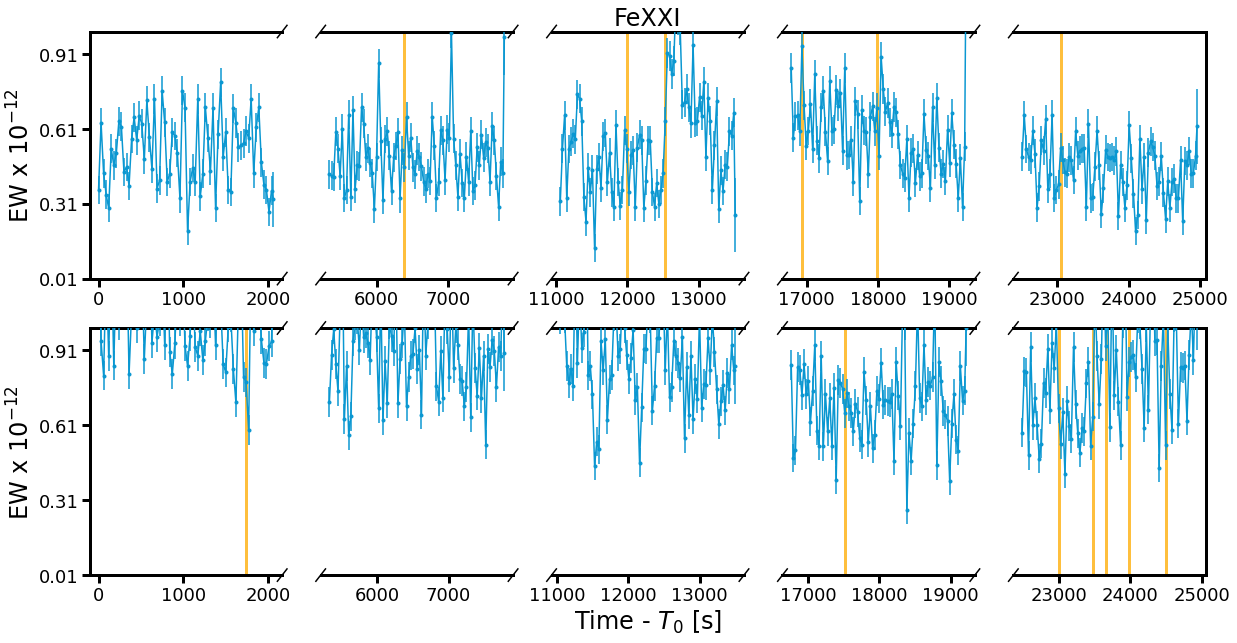

In [68]:
iron = [i for i in fwc.width_table.colnames if 'Fe' in i]

fig, axes = make_tworow()


for i in range(len(axes)):
    q = fwc.orbit == i
    
    if i < 5:
        t = fwc.time.value + 0.0
    else:
        t = visit2_time + 0.0
        
    
    axes[i].errorbar(t[q],
                     fwc.width_table[iron[1]].data[q], 
                     yerr=fwc.error_table[iron[1]].data[q]/10,
                     marker='.',  color=parula[80], zorder=3)
    
    inds = np.where(np.array(flare_mask[1])==i)[0]
    
    if len(inds)>0:
        for n in inds:
            argmax = np.argmax(fwc.width_table['SiIII'][flare_mask[2][n]>0])
            axes[i].vlines(t[flare_mask[2][n]>0][argmax],
                           0, 1, color=parula[215], lw=3, zorder=1)#, linestyle='--')
    
    if i == 2:
        axes[i].set_title(iron[1], fontsize=24)
        
    #axes[i].set_ylim(0.9e-12,1e-14)
    axes[i].set_ylim(1e-14,1e-12)
        
    if i == 0 or i == 5:
        axes[i].set_ylabel('EW x 10$^{-12}$', fontsize=24)
        axes[i].set_yticks(np.arange(1e-14,1e-12, 3e-13))
        axes[i].set_yticklabels(np.arange(1e-14,1e-12, 3e-13)/1e-12)
    if i == 7:
        axes[i].set_xlabel('Time - $T_0$ [s]', fontsize=24)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/FeXXI.png', dpi=250,
#            rasterize=True, bbox_inches='tight')

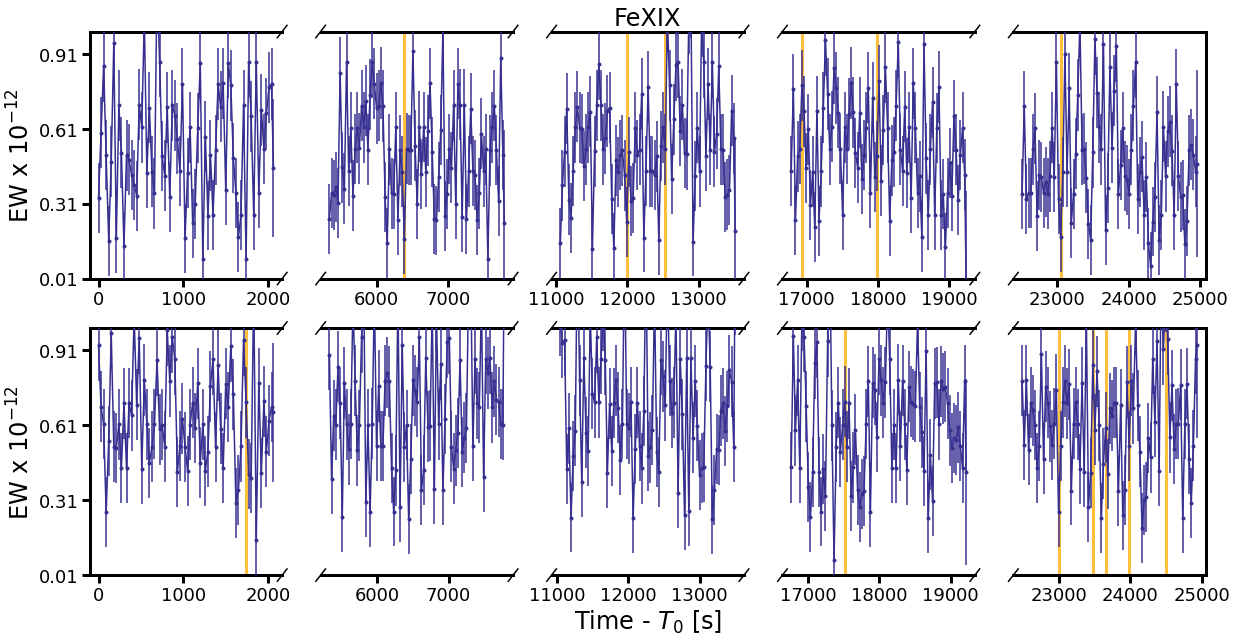

In [69]:
iron = [i for i in fwc.width_table.colnames if 'Fe' in i]

fig, axes = make_tworow()


for i in range(len(axes)):
    q = fwc.orbit == i
    
    if i < 5:
        t = fwc.time.value + 0.0
    else:
        t = visit2_time + 0.0
    
    axes[i].errorbar(t[q],
                     fwc.width_table[iron[0]].data[q], 
                     yerr=fwc.error_table[iron[0]].data[q]/10,
                     marker='.',  color=parula[3], zorder=3)
    
    inds = np.where(np.array(flare_mask[1])==i)[0]
    if len(inds)>0:
        for n in inds:
            argmax = np.argmax(fwc.width_table['SiIII'][flare_mask[2][n]>0])
            axes[i].vlines(t[flare_mask[2][n]>0][argmax],
                           0, 1, color=parula[215], lw=3, zorder=1)#, linestyle='--')
    
    if i == 2:
        axes[i].set_title(iron[0], fontsize=24)
        
    #axes[i].set_ylim(0.9e-12,1e-14)
    axes[i].set_ylim(1e-14,1e-12)
        
    if i == 0 or i == 5:
        axes[i].set_ylabel('EW x 10$^{-12}$', fontsize=24)
        axes[i].set_yticks(np.arange(1e-14,1e-12, 3e-13))
        axes[i].set_yticklabels(np.arange(1e-14,1e-12, 3e-13)/1e-12)
    if i == 7:
        axes[i].set_xlabel('Time - $T_0$ [s]', fontsize=24)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/FeXIX.png', dpi=250,
#            rasterize=True, bbox_inches='tight')

# Creates the flare masks

In [ ]:
diff = np.where(np.diff(fwc.time.value)>100000)[0]
diff = [0, diff[0], len(fwc.time)-1]

fig, axes = plt.subplots(figsize=(25,8), nrows=2, ncols=5)
fig.set_facecolor('w')
axes = axes.reshape(-1)

f_tot = np.full((20,len(fwc.time.value)), False)
x = 0
a = 0
which_o = []
for i in range(len(diff)-1):
    if i == 0:
        jr = [0,5]
        axes[a].set_ylim(1e-13,4e-11)
    else:
        jr = [5,10]
        
        
    for j in range(jr[0], jr[1]):
        mask = np.where((fwc.time.value>=fwc.time.value[diff[i]]) &
                        (fwc.time.value<=fwc.time.value[diff[i+1]]) &
                        (fwc.orbit==j))
        axes[a].errorbar(fwc.time.value[mask], 
                     fwc.width_table['CIII'][mask], 
                     yerr=fwc.error_table['CIII'][mask]/3, 
                     marker='.', color='k',
                     linestyle='')
        axes[a].plot(fwc.time.value[mask], 
                     fwc.width_table['CIII'][mask], 'k')

        
        if j == 1:
            f = ((fwc.time.value>=6300) & (fwc.time.value<=6600))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 2:
            f1 = ((fwc.time.value>=11900) & (fwc.time.value<=12100))
            f2 = ((fwc.time.value>=12300) & (fwc.time.value<=13500)) 
            f = np.array([f1, f2])
            which_o.append(j)
            which_o.append(j)
        elif j == 3:
            f1 = ((fwc.time.value>=16800) & (fwc.time.value<=17100) )
            f2 = ((fwc.time.value>=17700) & (fwc.time.value<=18300) ) 
            f = np.array([f1, f2])
            which_o.append(j)
            which_o.append(j)
        elif j == 4:
            f1 = ((fwc.time.value>=22970) & (fwc.time.value<=23150) )
            f = np.array([f1])
            which_o.append(j)
        elif j == 5:
            f = ((fwc.time.value>=10238383) & (fwc.time.value<=10238593))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 8:
            f = ((fwc.time.value>=10254152) & (fwc.time.value<=10254452))
            f = f.reshape((1,len(f)))
            which_o.append(j)
        elif j == 9:
            f0 = ((fwc.time.value>=10259581) & (fwc.time.value<=10259781))
            f1 = ((fwc.time.value>=10260101) & (fwc.time.value<=10260351))
            f2 = ((fwc.time.value>10260351) & (fwc.time.value<=10260651))
            f3 = ((fwc.time.value>10260651) & (fwc.time.value<=10260851))
            f4 = ((fwc.time.value>10261151) & (fwc.time.value<=10261501))
            f = np.array([f0, f1, f2, f3, f4])
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
            which_o.append(j)
        else:
            f = None
            
            
        if f is not None:
            for k in range(len(f)):
                f_tot[x] = f[k] 
                m1 = f[k] == True
                #axes[a].errorbar(fwc.time.value[m1], 
                #             fwc.width_table['CIII'][m1], 
                #             yerr=fwc.error_table['CIII'][m1]/3, 
                #             marker='.', color=parula[(k*40)+30],
                #             linestyle='')
                axes[a].axvspan(fwc.time.value[m1][0], fwc.time.value[m1][-1],
                                color=parula[(k*40)+30], alpha=0.4)
                x += 1
            
        if j < 5:
            axes[a].set_ylim(1e-13,5e-11)
        else:
            axes[a].set_ylim(1e-12,4e-11)
            if j == 5:
                axes[a].set_ylabel('EW x $ 10^{-11}$', y=1.1, fontsize=26)
            if j == 7:
                axes[a].set_xlabel('Time [s]', fontsize=26)
                
        axes[a].set_yticklabels([1,2,3,4,5,6])
        if j < 5:
            axes[a].set_title('Visit 1; Orbit {}'.format(j+1))
        else:
            axes[a].set_title('Visit 2; Orbit {}'.format(j-4))
        axes[a].set_xlim(fwc.time.value[mask][0], fwc.time.value[mask][-1])
        a += 1
plt.subplots_adjust(hspace=0.4)
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/allflares.png', dpi=250, rasterize=True,
#            bbox_inches='tight')

In [ ]:
f_tot = np.delete(f_tot, np.arange(x,len(f_tot),1,dtype=int),axis=0)

In [ ]:
f_int = np.zeros(f_tot.shape, dtype=int)
for i in range(len(f_tot)):
    f_int[i] = (f_tot[i]+0.0)*2**(i+1)

In [107]:
#np.save('/Users/arcticfox/Documents/AUMic/flare_mask.npy', [fwc.time, which_o, f_int])

# If flare mask created, start below

In [70]:
_, which_o, f_int = np.load('/Users/arcticfox/Documents/AUMic/flare_mask.npy',
                            allow_pickle=True)

In [71]:
def multi_peaks(ttest, test):
    """
    test = time
    ttest = flux
    """

    #plt.plot(ttest, test-test.min(),'k')
    #plt.plot(ttest, test-test.min(), '.')

    p1 = np.argmax(test)
    #plt.plot(ttest[p1], test[p1], 'ro')
    
    try:
        arg = np.where((ttest.value>ttest[p1].value+100))[0]
        p2 = np.argmax(test[arg])
        plt.plot(ttest[arg][p2], test[arg][p2], 'bo')
    except:
        arg=np.arange(0,len(ttest),1,dtype=int)
        p2=0
        
    try:
        arg3 = np.where((ttest.value>ttest[arg][p2].value+100))[0]
        p3 = np.argmax(test[arg3])
        plt.plot(ttest[arg3][p3], test[arg3][p3], 'ko')

    except:
        arg3=np.arange(0,len(ttest),1,dtype=int)
        p3=0
        
    t0 = np.array([ttest[p1].value, ttest[arg][p2].value, ttest[arg3][p3].value])
    amp = np.array([test[p1], test[arg][p2], test[arg3][p3]])#/1e-13

    return t0, amp

In [72]:
%load_ext autoreload
%autoreload 2
sys.path.append('/Users/arcticfox/Documents/GitHub/cos_flares/src/')
from utils import *
from cos_flares import FlaresWithCOS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visit 1 Orbit 2 flares

In [73]:
ions = ['SiII', 'SiIII', 'CIII','NV_1','NV_2', 'FeXXI']

SiII


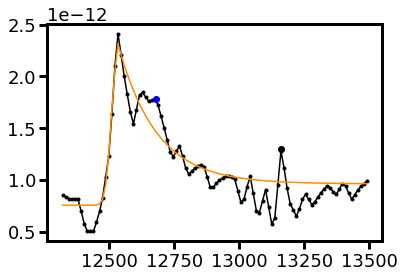

SiIII


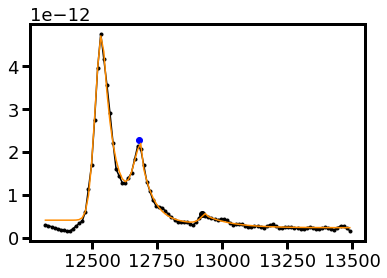

CIII


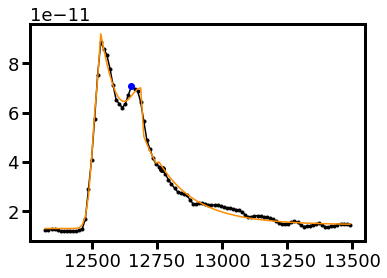

NV_1


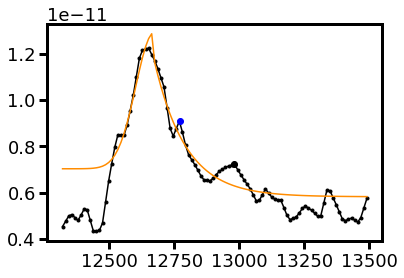

NV_2


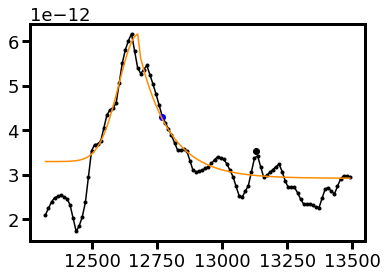

FeXXI


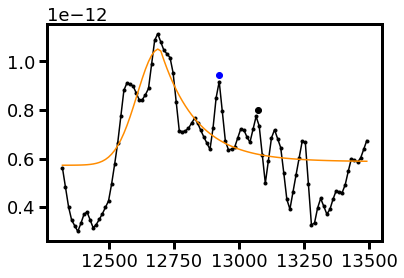

In [74]:
fmodels = []

mask = f_int[2] > 0
tmp1 = []

for ion in ions:
    print(ion)
    
    upsample = np.linspace(fwc.time[mask].min(), fwc.time[mask].max(), 100)
    finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask])
    einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask])
    
    plt.plot(upsample, 
             finterp(upsample),
             marker='.', color='k')
    t0, amp = multi_peaks(fwc.time[mask], fwc.width_table[ion][mask])
    rise, decay = [10,10,10],[50,50,50] 
    
    
    if ion == 'SiIII' or ion == 'CIII':
        out = fwc.fit_flare(ion=ion, mask=mask, amp=amp,
                                  t0=t0, rise=rise, decay=decay, x=upsample.value)
    #elif ion == 'SiII':
    #    out = fwc.fit_flare(ion=ion, mask=mask, amp=amp[:2],
    #                              t0=t0[:2], rise=rise[:2], decay=decay[:2], 
    #                              x=upsample.value)
    else:
        out = fwc.fit_flare(ion=ion, mask=mask, amp=amp[:1],
                                  t0=t0[:1], rise=rise[:1], decay=decay[:1], 
                                  x=upsample.value)
    plt.plot(upsample, out[-1].best_fit, color='darkorange')
    tmp1.append(out)
    plt.show()

fmodels.append(tmp1)

## Visit 2 Orbit 5 flares

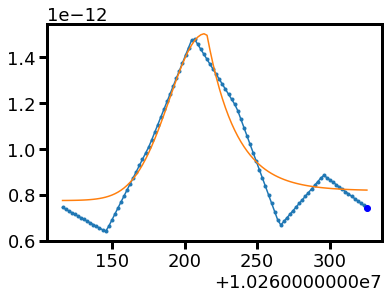

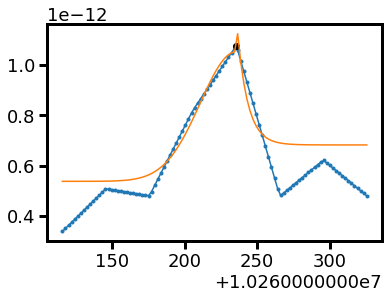

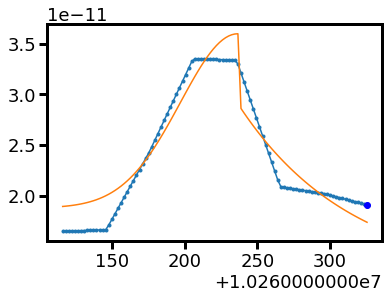

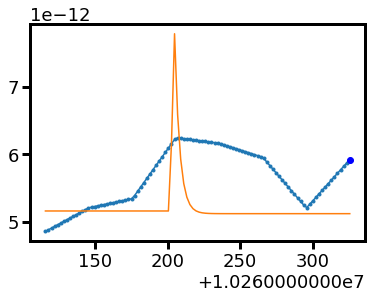

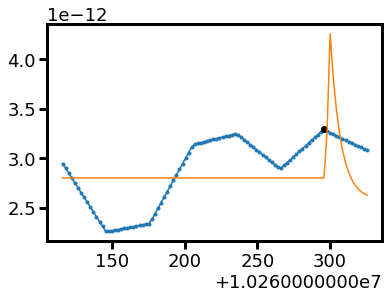

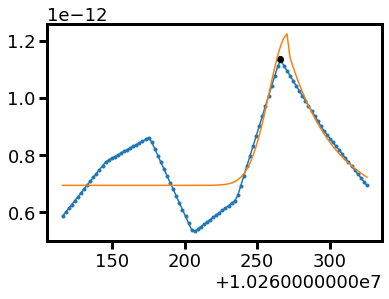

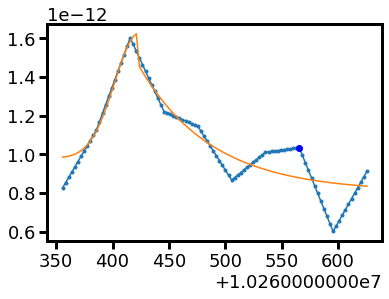

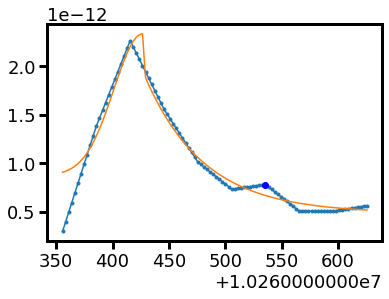

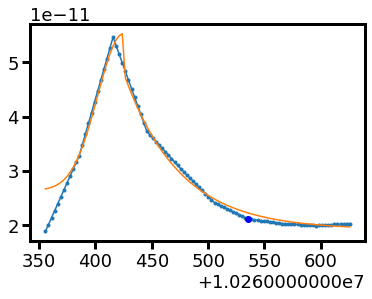

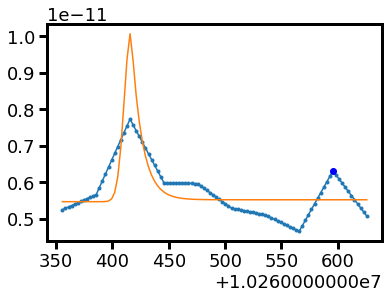

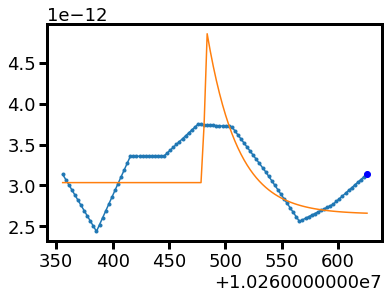

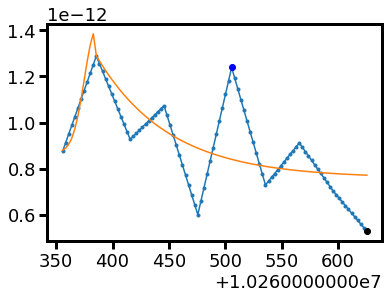

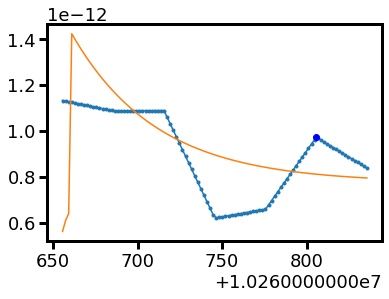

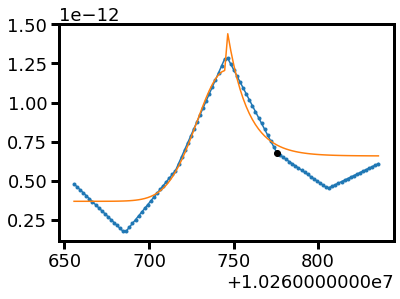

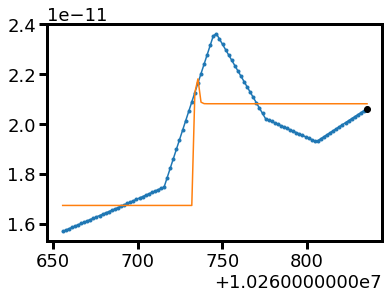

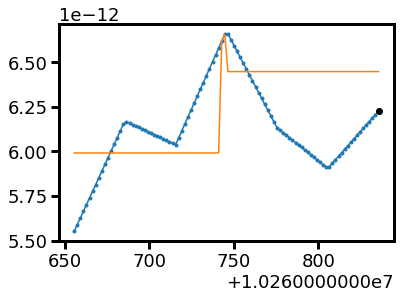

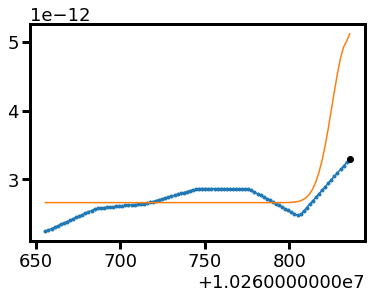

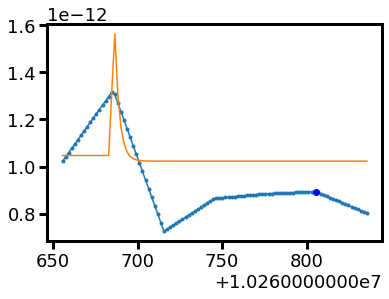

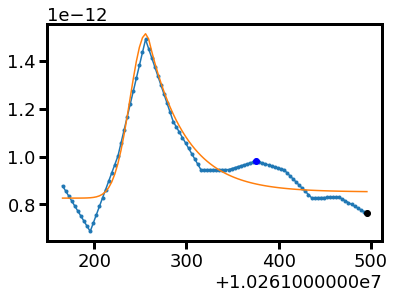

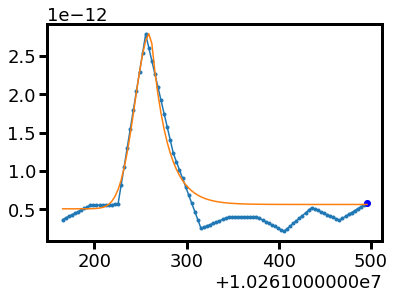

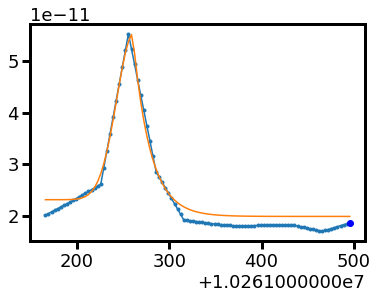

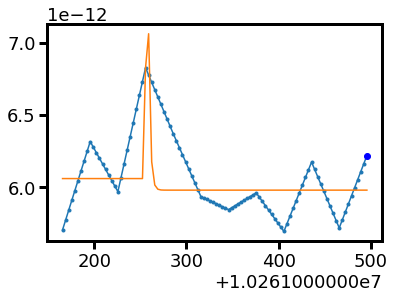

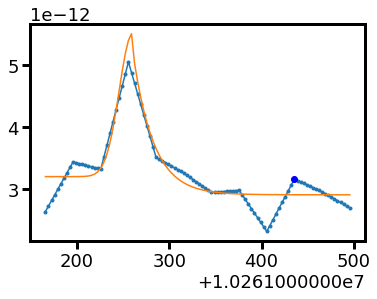

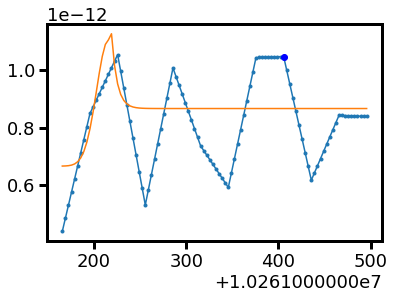

In [75]:
fmodels_25 = []

for j in np.arange(-4,0,1,dtype=int):
    temp_f = []
    temp_l = []
    mask = f_int[j] > 0
    
    for ion in ions:

        upsample = np.linspace(fwc.time[mask].min(), fwc.time[mask].max(), 100)
        finterp = interp1d(fwc.time[mask], fwc.width_table[ion][mask])
        einterp = interp1d(fwc.time[mask], fwc.error_table[ion][mask])

        plt.plot(upsample, 
                 finterp(upsample),
                 marker='.')

        t0, amp = multi_peaks(fwc.time[mask], fwc.width_table[ion][mask])
            
        rise, decay = [10,10,10],[50,50,50] 

        out = fwc.fit_flare(ion=ion, mask=mask, amp=amp[:1],
                                      t0=t0[:1], rise=rise[:1], decay=decay[:1], 
                                      x=upsample.value)

        plt.plot(upsample, out[-1].best_fit)
        temp_f.append(out)
        plt.show()

    fmodels.append(temp_f)

In [76]:
oot = np.nansum(f_int, axis=0)==0
qlines = []
for ion in ions:
    ngauss = fwc.line_table[fwc.line_table['ion']==ion]['ngauss'].value[0] + 0
    args = fwc.model_line_shape(ion=ion,
                                mask=oot, 
                                ngauss=ngauss, 
                                ext=50)
    qlines.append(args)

//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=2.38e-14 +/- 5.29e-14); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,
//anaconda3/lib/python3.7/site-packages/lightkurve/lightcurve.py:1048: LightkurveWarning: The light curve appears to be zero-centered (median=1.23e-14 +/- 2.63e-14); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  LightkurveWarning,


In [77]:
def duration(zeroed, time):
    med = np.nanmedian(zeroed)
    qmask = zeroed<0.5*med
    fmask = zeroed>=0.5*med
    fq = np.nanmedian(zeroed[qmask])
    
    plt.plot(time[fmask], zeroed[fmask],'.')
    plt.plot(time[qmask], zeroed[qmask],'.')
    plt.show()
    return np.trapz(((zeroed[fmask]-fq)/fq),x=time[fmask]*units.s)

okay
okay
okay
okay
-4 3
okay
okay
okay
okay
-3 3
okay
okay
okay
okay
okay
okay
-1 3


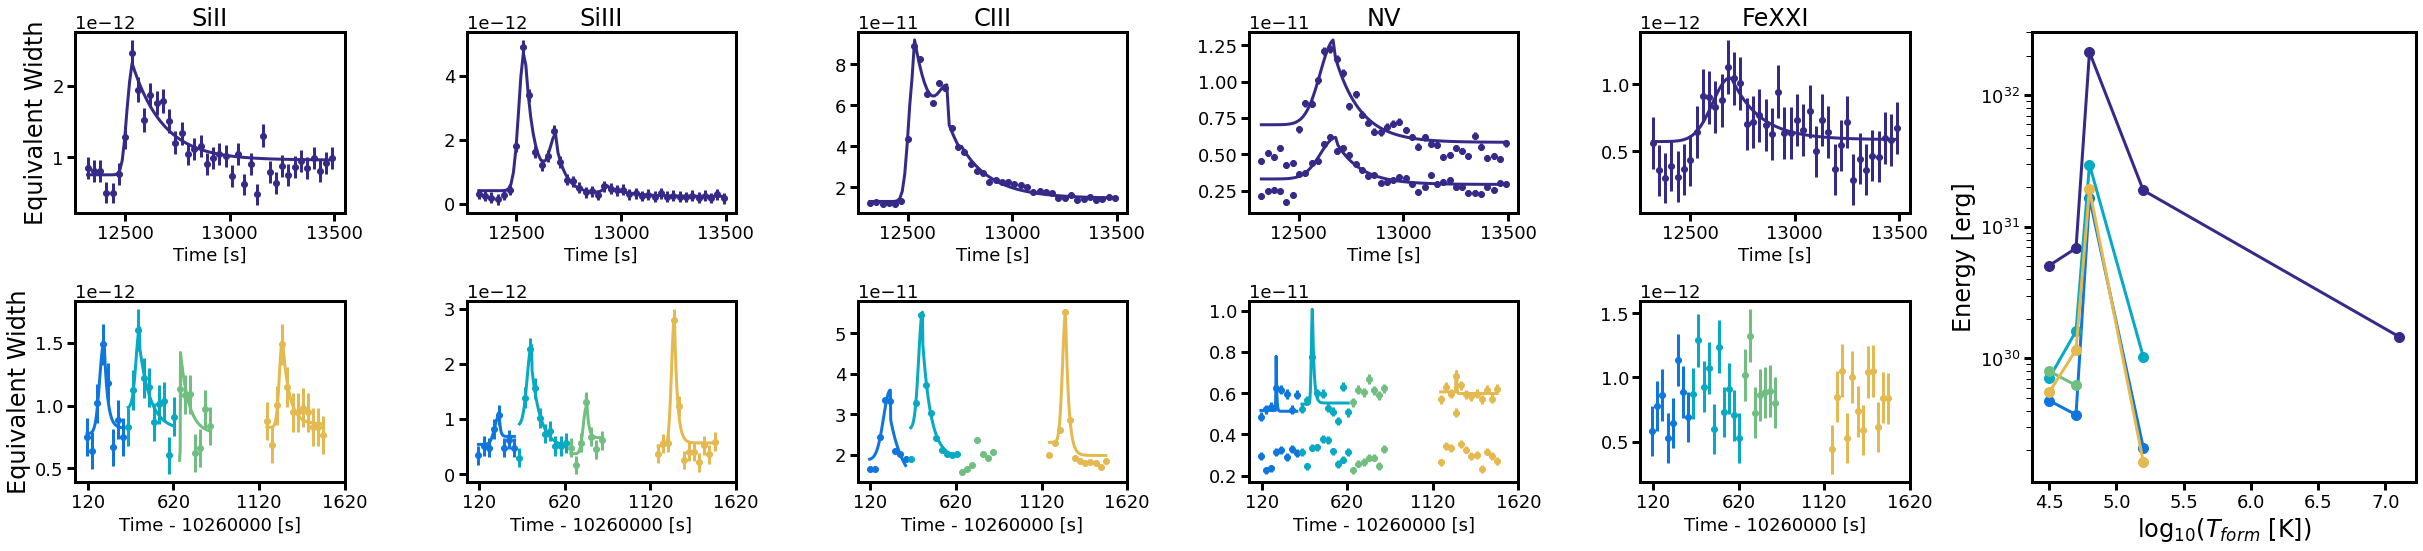

In [83]:
fig = plt.figure(tight_layout=True, figsize=(34,8))
fig.set_facecolor('w')
gs = gridspec.GridSpec(2,6, width_ratios=[3.5,3.5,3.5,3.5,3.5,5])
ax11 = fig.add_subplot(gs[0,0])
ax33 = fig.add_subplot(gs[0,1])
ax55 = fig.add_subplot(gs[0,2])
ax77 = fig.add_subplot(gs[0,4])
ax99 = fig.add_subplot(gs[0,3])

ax1 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax7 = fig.add_subplot(gs[1,4])
ax9 = fig.add_subplot(gs[1,3])

eax = fig.add_subplot(gs[0:,5:])

faxes = [ax1,ax3,ax5,ax9,0,ax7]
bigax = [ax11,ax33,ax55,ax99,0,ax77]
#laxes = [ax2,ax4,ax6,ax8]

if COLOR == 'k':
    ion_colors = parula[np.linspace(0,200,5,dtype=int)]
else:
    ion_colors = parula[np.linspace(80,255,5,dtype=int)]
    
formtemp = np.array([4.5, 4.7, 4.8, 5.2, 7.1])
x = 0
ind = [2,-4,-3,-2,-1]
energies = []
durations = []

for n in range(len(fmodels)):
    tempe = []
    tempd = []
    for i in [0,1,2,3,5]:
        mask = f_int[ind[n]] > 0
        qmask = f_int[ind[n]] == 0

        if n == 0:
            bigax[i].errorbar(fwc.time[mask].value,
                              fwc.width_table[ions[i]][mask],
                              yerr=fwc.error_table[ions[i]][mask].value/3, 
                              c=ion_colors[x], linestyle='', lw=3, marker='o')

            bigax[i].plot(fmodels[n][i][0],
                      fmodels[n][i][-1].best_fit,
                      c=ion_colors[x], lw=3)
            
            bigax[i].set_title(ions[i], fontsize=24)
            
            
            if i == 3:
                bigax[i].errorbar(fwc.time[mask].value,
                              fwc.width_table[ions[i+1]][mask],
                              yerr=fwc.error_table[ions[i+1]][mask].value/3, 
                              c=ion_colors[x], linestyle='', lw=3, marker='o')

                bigax[i].plot(fmodels[n][i+1][0],
                              fmodels[n][i+1][-1].best_fit,
                              c=ion_colors[x], lw=3)
                bigax[i].set_title('NV', fontsize=24)

            bigax[i].set_xticks([12500, 13000, 13500])
            
            bigax[i].set_xlabel('Time [s]')
            bigax[i].set_rasterized(True)
    
            
            zeroed = fmodels[n][i][-1].best_fit - np.nanmin(fmodels[n][i][-1].best_fit)
            e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                              x=fmodels[n][i][0]*units.s)*4*np.pi*distance**2
            _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                               flux=fwc.width_table[ions[i]])
        
        else:
            
            faxes[i].errorbar(fwc.time[mask].value,
                             fwc.width_table[ions[i]][mask],
                              yerr=fwc.error_table[ions[i]][mask]/3,
                             c=ion_colors[x], linestyle='', lw=3, marker='o')
            
            if i == 3:
                faxes[i].errorbar(fwc.time[mask].value,
                                  fwc.width_table[ions[i+1]][mask],
                                  yerr=fwc.error_table[ions[i+1]][mask]/3,
                                  c=ion_colors[x], linestyle='', lw=3, marker='o')

            if ((ions[i] == 'CIII' and ind[n] != -2) or 
                (ions[i]=='NV_1' and ind[n]!=-2) or
                (ions[i]=='NV_2' and ind[n]!=-2) or
                ((ions[i]=='SiIII') or (ions[i]=='SiII'))):# or (ions[i]=='NV_1') )):
                 #or (ions[i]=='NV_2'))):
                print('okay')
                faxes[i].plot(fmodels[n][i][0],
                              fmodels[n][i][-1].best_fit,
                              c=ion_colors[x], lw=3)
                
                if ions[i] == 'NV_1':
                    print(ind[n],i)
                
                zeroed = fmodels[n][i][-1].best_fit - np.nanmin(fmodels[n][i][-1].best_fit)
                e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
                              x=fmodels[n][i][0]*units.s)*4*np.pi*distance**2
                
                _,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                                               flux=fwc.width_table[ions[i]])
                
                

            else:
                e = 0*units.s
                d = 0*units.s
                
            if ions[i] == 'CIII' and ind[n]==-2:
                e = 0*units.s
                d = 0*units.s
                
                
            faxes[i].set_xticks(np.array([10260120, 10260620, 10261120, 10261620]))
            faxes[i].set_xticklabels(np.array([10260120, 10260620, 10261120, 10261620])-10260000)
            faxes[i].set_xlabel('Time - 10260000 [s]')
            faxes[i].set_rasterized(True)
        
        tempe.append(e.value)
        tempd.append(d.value)
        
    x += 1
    energies.append(tempe)
    durations.append(tempd)
    
    #ax3.plot(formtemp[i], e, 'o', ms=10)
    
for i in range(len(fmodels)):
    q = np.array(energies[i]) > 0
    eax.plot(formtemp[q], np.array(energies[i])[q], 
             c=ion_colors[i] ,marker='o', lw=3, ms=10)
eax.set_yscale('log')
eax.set_ylabel('Energy [erg]',fontsize=24)
eax.set_xlabel('log$_{10}$($T_{form}$ [K])',fontsize=24)
    
#ax11.set_title('Visit 1 Orbit 2')
#ax1.set_title('Visit 2 Orbit 5')
#ax3.set_yscale('log')
ax11.set_ylabel('Equivalent Width', fontsize=24)
ax1.set_ylabel('Equivalent Width', fontsize=24)


plt.subplots_adjust(wspace=0.)
#plt.savefig('/Users/arcticfox/Documents/AUMic/paper/models.pdf', rasterize=True,
#            dpi=300, bbox_inches='tight')#, transparent=True)

Text(0.5, 0, 'Wavelength [$\\AA$]')

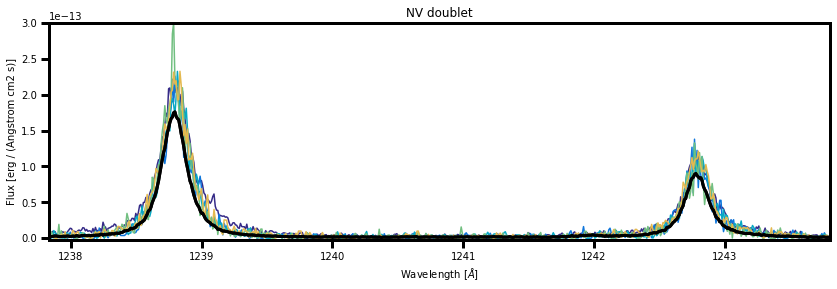

In [17]:
fig, ax = plt.subplots(figsize=(14,4), sharey=True)
fig.set_facecolor('w')
q = np.nansum(f_int,axis=0)==0
med = np.nanmean(fwc.flux[q],axis=0)
#q = med > 0
ax.plot(fwc.wavelength[0], med, color='k', lw=3, zorder=6)
ax.plot(fwc.wavelength[0], med, color='k',lw=3, zorder=6)

for j,i in enumerate([2,-4,-3,-2,-1]):
    med = np.nanmean(fwc.flux[f_int[i]>0,:], axis=0)
    #q = med>0
    ax.plot(fwc.wavelength[0], med, color=ion_colors[j])

ax.set_xlim(1238.831-1,1242.804+1)
#ax.set_yscale('log')
ax.set_ylim(-3e-15,3e-13)
plt.title('NV doublet')
plt.ylabel('Flux [{}]'.format(fwc.flux_units))
plt.xlabel('Wavelength [$\AA$]')
#plt.savefig('/Users/arcticfox/Documents/AUMic/figures/nitrogen_doublet.png',
#         rasterize=True, bbox_inches='tight', dpi=250)

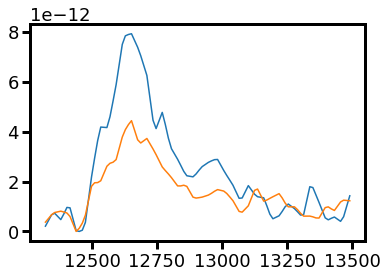

In [99]:
i = 3
n = 0
zeroed = fmodels[n][i][-1].best_fit - np.nanmin(fmodels[n][i][-1].best_fit)

plt.plot(fmodels[n][i][0], fmodels[n][i][1]-np.nanmin(fmodels[n][i][1]))
plt.plot(fmodels[n][i+1][0], fmodels[n][i+1][1]-np.nanmin(fmodels[n][i+1][1]))

e = np.trapz(zeroed*units.erg/units.s/units.cm**2, 
              x=fmodels[n][i][0]*units.s)*4*np.pi*distance**2

_,d = fwc.measure_flare_params(qmask=qmask, fmask=mask, d=distance,
                               flux=fwc.width_table[ions[i]])